# Logistic regression example

We will use Logistic Regression to calculate the probability for a student to pass an exam given the number of hours of study and number of hours slept:

$$p(\text{passed}) = \sigma(w_0 + w_1 \cdot \text{hours studied} + w_2 \cdot \text{hours slept})$$

### Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize # for fit
%matplotlib inline
rng = np.random.RandomState(0)

## 1. Data visualization

In [2]:
# Load and read file
from numpy import genfromtxt
my_data = genfromtxt('data_student_exams.csv', delimiter=',')
print('%10s %10s %8s'% ('Studied', 'Slept', 'Passed'))

# Print first 10 entries
print(my_data[:10,:])

   Studied      Slept   Passed
[[0.     0.     0.    ]
 [7.4517 1.0466 0.    ]
 [4.5133 0.8208 0.    ]
 [7.1874 8.4608 1.    ]
 [0.     6.8263 0.    ]
 [0.379  4.039  0.    ]
 [9.7729 6.9286 1.    ]
 [6.5881 0.1785 1.    ]
 [2.5981 3.0238 0.    ]
 [3.9293 2.9235 1.    ]]


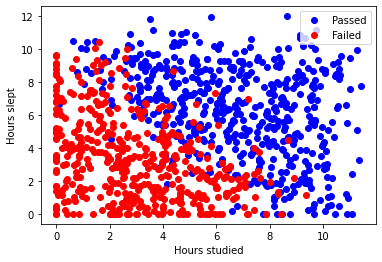

In [3]:
labels = my_data[:,2]
student_passed = my_data[labels==1]
student_failed = my_data[labels==0]

slept1 = student_passed[:,1]
studied1 = student_passed[:,0]

slept0 = student_failed[:,1]
studied0 = student_failed[:,0]

plt.plot(studied1, slept1, 'o', c='b', label='Passed')
plt.plot(studied0, slept0, 'o', c='r', label='Failed')
plt.xlabel('Hours studied')
plt.ylabel('Hours slept')
plt.legend();

## 2. Separate data in train and test sample

In [4]:
# Data features: [1, studied, slept]
features = my_data[:,0:2]
bias = np.ones(shape=(len(features),1))
features = np.append(bias, features, axis=1)

# N examples for train and test
N=500

features_train = features[0:N,:]
labels_train = labels[0:N]
features_test = features[N:-1,:]
labels_test = labels[N:-1]

## 3. Sigmoid function

In [5]:
def sigmoid(x):
    sigma = 1/(1+np.exp(-x))
    return sigma

def dsig(x):
    deriv = sigmoid(x)*(1-sigmoid(x))
    return deriv

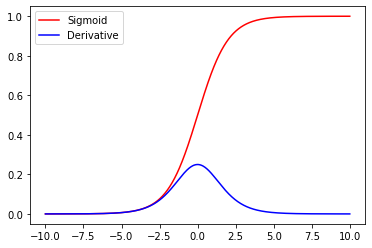

In [6]:
x = np.linspace(-10,10,1000)
plt.plot(x, sigmoid(x), c='r', label='Sigmoid')
plt.plot(x, dsig(x), c='b', label='Derivative')
plt.legend();

## 4. Building a predictive model

### Functions needed for training

In [7]:
def predict(features, weights):
    '''
    Returns 1D array of probabilities
    that the class label == 1
    '''
    z = np.dot(features, weights)
    return sigmoid(z)

def cost_function(features, labels, weights):
    '''
    Cross-Entropy cost function

    Features:(100,3)
    Labels: (100,1)
    Weights:(3,1)
    Returns 1D matrix of predictions
    Cost = sum ( labels*log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = len(labels)

    predictions = predict(features, weights)

    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1-labels)*np.log(1-predictions)

    #Take the sum of both costs
    cost = class1_cost - class2_cost

    #Take the average cost
    cost = cost.sum()/observations

    return cost

def update_weights(features, labels, weights, lr):
    '''
    Gradient Descent

    Features:(100, 3)
    Labels: (100, 1)
    Weights:(3, 1)
    '''
    N = len(features)

    #1 - Get Predictions
    predictions = predict(features, weights)

    #2 Transpose features from (100, 3) to (3, 100)
    # So we can multiply w the (100,1)  cost matrix.
    # Returns a (3,1) matrix holding 3 partial derivatives --
    # one for each feature -- representing the aggregate
    # slope of the cost function across all observations
    gradient = np.dot(features.T,  predictions - labels)
    
    #3 Take the average cost derivative for each feature
    gradient /= N

    #4 - Multiply the gradient by our learning rate
    gradient *= lr
    
    #5 - Subtract from our weights to minimize cost
    weights -= gradient

    return weights

def train(features, labels, weights, lr, iters):
    """
    Training using gradient descent
    """
    cost_history = []

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)
        
    return weights, cost_history

## 5. Training

[-12.6460271    1.48600406   1.22283211]


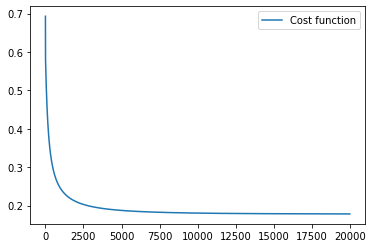

In [8]:
# Initialize weights
weights = np.array([0.0,0.0,0.0])

# Calculate weights with gradient descent
Niter=20000
learning_speed = 0.1

COST=[]
for i in range(Niter):
    COST.append(cost_function(features_train, labels_train, weights))
    weights = update_weights(features_train, labels_train, weights, learning_speed)
    
    
print(weights)
plt.plot(np.linspace(0,Niter,len(COST)),COST, label='Cost function')
plt.legend();

## 6. Accuracy of predictions

In [9]:
threshold = 0.5
predictions = predict(features_train, weights)
pred_train = [0 if predictions[i] <= threshold else 1 for i in range(len(predictions))]

comparison = [1 if pred_train[i]==labels_train[i] else 0 for i in range(len(pred_train))]
print(np.sum(comparison)/500)

0.924


In [10]:
predictions = predict(features_test, weights)
pred_test = [0 if predictions[i] <= threshold else 1 for i in range(len(predictions))]

comparison = [1 if pred_test[i]==labels_test[i] else 0 for i in range(len(pred_test))]
print(np.sum(comparison)/500)

0.888


## 7. Show results (with probabilities)

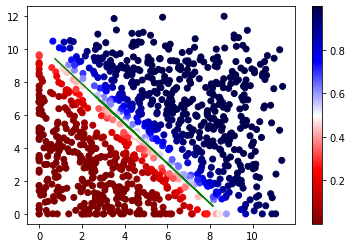

In [11]:
from matplotlib import cm 
prob = predict(features, weights)
initial_cmap = cm.get_cmap('seismic')
reversed_cmap=initial_cmap.reversed()
plt.scatter(features[:,1], features[:,2], marker='o', c=prob, cmap=reversed_cmap)
plt.colorbar()

x=[]
y=[]
for i in range(len(features)):
    if prob[i] < 0.51 and prob[i] > 0.49:
        x.append(features[i,1])
        y.append(features[i,2])
        
        
plt.plot(x,y,c='g');

## 8. Predicted probability distributions

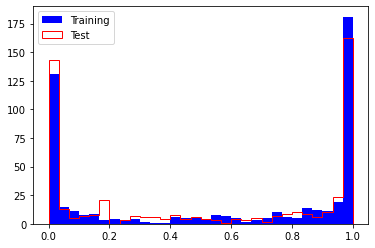

In [12]:
prob_train = predict(features_train, weights)
prob_test = predict(features_test, weights)
plt.hist(prob_train, color='b',bins=30,label='Training')
plt.hist(prob_test, color='r',bins=30, label='Test', histtype='step')
plt.legend();

## 9. Confusion matrix

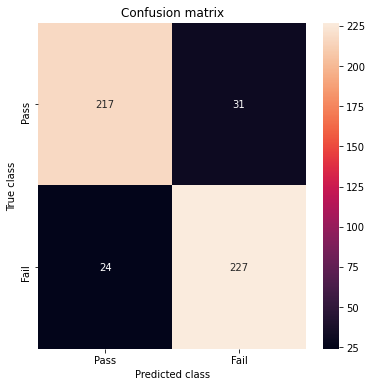

False positive rate = 9.56 %
True positive rate = 87.50 %


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

LABELS = ["Pass", "Fail"]

threshold = 0.5

y_pred = [1 if e > threshold else 0 for e in prob_test]
conf_matrix = confusion_matrix(labels_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

PP = conf_matrix[0,0]
PF = conf_matrix[0,1]
FP = conf_matrix[1,0]
FF = conf_matrix[1,1]
print('False positive rate = %.2f %%' % (FP/(FP+FF)*100))
print('True positive rate = %.2f %%' % (PP/(PP+PF)*100))

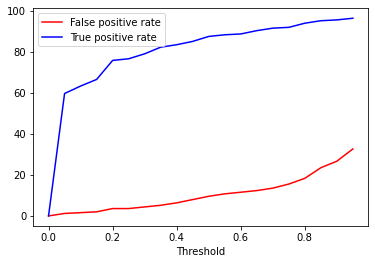

In [14]:
T=np.arange(0,1,0.05)
false=[]
true=[]
for t in T:
    threshold = t
    y_pred = [1 if e > threshold else 0 for e in prob_test]
    conf_matrix = confusion_matrix(labels_test, y_pred)
    PP = conf_matrix[0,0]
    PF = conf_matrix[0,1]
    FP = conf_matrix[1,0]
    FF = conf_matrix[1,1]
    #print('False positive rate = %.2f %%' % (FP/(FP+FF)*100))
    #print('True positive rate = %.2f %%' % (PP/(PP+PF)*100))
    false.append((FP/(FP+FF)*100))
    true.append((PP/(PP+PF)*100))
    
plt.plot(T, false,c='r', label='False positive rate')
plt.plot(T, true,c='b', label='True positive rate')
plt.legend()
plt.xlabel('Threshold');

## ROC Curve

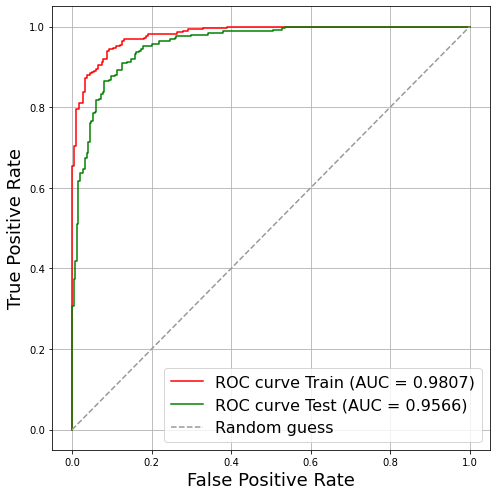

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

#target = np.concatenate((np.zeros(x_train.shape[0]),np.ones(x_test.shape[0])))
#scores = np.concatenate((norm_train,norm_test))  

plt.figure(figsize=(7, 7))
# Train set                   
fp, vp, thresholds = roc_curve(labels_train,prob_train,pos_label=1,drop_intermediate='False')
roc_auc = auc(fp, vp)
plt.plot(fp,vp,color='red',label='ROC curve Train (AUC = %0.4f)'%(roc_auc))
# Test set                   
fp, vp, thresholds = roc_curve(labels_test,prob_test,pos_label=1,drop_intermediate='False')
roc_auc = auc(fp, vp)
plt.plot(fp,vp,color='green',label='ROC curve Test (AUC = %0.4f)'%(roc_auc))

plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='Random guess')
plt.grid()
plt.legend(loc="best",fontsize=16)
plt.tight_layout()
#plt.savefig("images/ROC.png")